In [1]:
import yfinance as yf
import pandas as pd
import sqlite3

# 1. Список компаний
tickers = ['AAPL', 'MSFT', 'GOOGL', 'NVDA']

# 2. Скачиваем данные за 2 года
raw_data = yf.download(tickers, period='2y')

# 3. Твоя любимая очистка MultiIndex (делаем заголовки плоскими)
# Мы сохраняем оба уровня, чтобы знать где цена, а где тикер
cols = []
for col in raw_data.columns:
    cols.append(f"{col[0]}_{col[1]}") 
raw_data.columns = cols

# 4. Сбросим индекс, чтобы Date стала колонкой
df = raw_data.reset_index()

# 5. Перевод из "широкого" формата в "длинный" (для SQL)
# Это сделает таблицу удобной: Date | Ticker | Close | Open ...
final_df = pd.melt(df, id_vars=['Date'], var_name='Metric_Ticker')

# Разделяем Metric_Ticker (например, Close_AAPL) на две колонки
final_df[['Metric', 'Ticker']] = final_df['Metric_Ticker'].str.split('_', expand=True)

# Разворачиваем метрики обратно в колонки, но сохраняем тикеры строками
df_stocks = final_df.pivot(index=['Date', 'Ticker'], columns='Metric', values='value').reset_index()

# 6. Добавляем Daily_Change для аналитики
df_stocks['Daily_Change'] = ((df_stocks['Close'] - df_stocks['Open']) / df_stocks['Open'] * 100).round(2)

# Создаем подключение и сохраняем в базу
conn = sqlite3.connect('market_data.db')
df_stocks.to_sql('stocks_comparison', conn, if_exists='replace', index=False)

print("Данные загружены! Таблица 'stocks_comparison' готова.")
print(df_stocks.head())

[*********************100%***********************]  4 of 4 completed

Данные загружены! Таблица 'stocks_comparison' готова.
Metric       Date Ticker       Close        High         Low        Open  \
0      2023-12-26   AAPL  191.243896  192.076034  191.025954  191.798655   
1      2023-12-26  GOOGL  140.458755  141.610045  140.131228  140.528223   
2      2023-12-26   MSFT  369.155945  371.402449  368.012983  369.490946   
3      2023-12-26   NVDA   49.251560   49.572381   48.932738   48.940733   
4      2023-12-27   AAPL  191.342972  191.689703  189.302247  190.689158   

Metric       Volume  Daily_Change  
0        28919300.0         -0.29  
1        16780300.0         -0.05  
2        12673100.0         -0.09  
3       244200000.0          0.64  
4        48087700.0          0.34  


In [9]:
query = """
SELECT 
    strftime('%Y-%m', Date) AS Month, Ticker,
    ROUND(AVG(Close), 2) AS Avg_Month_Price,
    DENSE_RANK() OVER(
        PARTITION BY strftime('%Y-%m', Date)
        ORDER BY ROUND(AVG(Close), 2) DESC
        ) AS Rank
FROM stocks_comparison
GROUP BY Ticker, Month
ORDER BY Month DESC, Rank ASC
"""
pd.read_sql(query, conn)
    

,Month,Ticker,Avg_Month_Price,Rank
0,2025-12,MSFT,483.28,1
1,2025-12,GOOGL,312.24,2
2,2025-12,AAPL,277.04,3
3,2025-12,NVDA,181.03,4
4,2025-11,MSFT,496.15,1
...,...,...,...,...
95,2024-01,NVDA,56.23,4
96,2023-12,MSFT,369.50,1
97,2023-12,AAPL,191.27,2
98,2023-12,GOOGL,139.40,3


In [14]:
query = """
SELECT Daily_Change, Date, Ticker
FROM stocks_comparison
WHERE Daily_Change <= -4
ORDER BY Daily_Change ASC
"""
pd.read_sql(query, conn)


,Daily_Change,Date,Ticker
0,-11.00,2025-02-27 00:00:00,NVDA
1,-8.42,2025-01-07 00:00:00,NVDA
2,-8.36,2024-04-19 00:00:00,NVDA
3,-8.26,2024-08-07 00:00:00,NVDA
4,-8.00,2024-03-08 00:00:00,NVDA
5,-7.81,2025-11-20 00:00:00,NVDA
6,-7.74,2025-05-07 00:00:00,GOOGL
7,-7.65,2025-03-03 00:00:00,NVDA
8,-7.65,2025-04-08 00:00:00,AAPL
9,-7.23,2025-04-08 00:00:00,NVDA


In [29]:
query = """
SELECT
    strftime('%Y-%m', Date) AS Month,
    ROUND(AVG(CASE WHEN Ticker = 'AAPL' THEN Daily_Change END), 2) AS APPL_Avg,
    ROUND(AVG(CASE WHEN Ticker = 'NVDA' THEN Daily_Change  END), 2) AS NVDA_Avg,
    ROUND(AVG(CASE WHEN Ticker = 'GOOGL' THEN Daily_Change  END), 2) AS GOOGL_Avg,
    ROUND(AVG(CASE WHEN Ticker = 'MSFT' THEN Daily_Change  END), 2) AS MSFT_Avg
FROM stocks_comparison
GROUP BY Month
ORDER BY Month DESC
"""
pd.read_sql(query, conn)

,Month,APPL_Avg,NVDA_Avg,GOOGL_Avg,MSFT_Avg
0,2025-12,-0.12,0.14,-0.25,0.23
1,2025-11,0.31,-0.66,-0.00,-0.20
2,2025-10,-0.08,-0.26,0.20,-0.17
3,2025-09,0.24,0.36,0.30,-0.03
4,2025-08,0.17,0.15,0.51,-0.40
5,2025-07,-0.02,-0.02,0.11,-0.10
6,2025-06,-0.12,0.44,0.04,0.35
7,2025-05,-0.09,0.40,-0.12,0.23
8,2025-04,0.81,1.04,0.34,0.55
9,2025-03,-0.13,-0.29,-0.10,0.11


In [30]:
pandas_pivot = df_stocks.pivot_table(
    index = df_stocks['Date'].dt.strftime('%Y-%m'),
    columns = 'Ticker',
    values = 'Daily_Change',
    aggfunc = 'mean'
).round(2)
display(pandas_pivot)

Ticker,AAPL,GOOGL,MSFT,NVDA
Date,,,,
2023-12,-0.24,-0.32,0.00,-0.09
2024-01,0.08,0.22,0.09,0.70
2024-02,0.06,0.00,0.08,0.22
2024-03,-0.05,0.06,0.02,0.12
2024-04,-0.03,0.25,-0.44,-0.40
2024-05,-0.08,0.38,0.14,0.36
2024-06,0.16,0.25,0.37,0.09
2024-07,0.02,-0.29,-0.15,-0.73
2024-08,0.44,0.00,-0.15,0.38


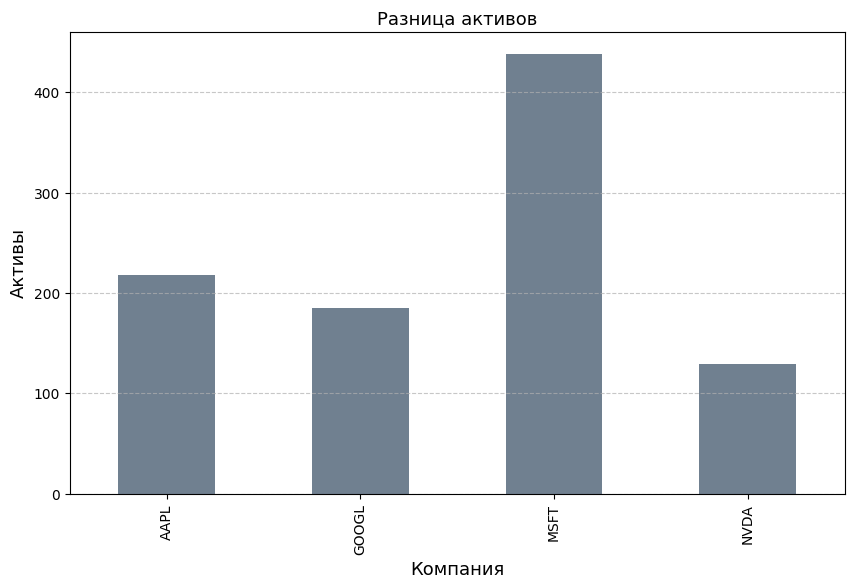

In [35]:
import matplotlib.pyplot as plt
visul = df_stocks.groupby('Ticker')['Close'].mean()
plt.figure(figsize=(10,6))
visul.plot(kind='bar', color='slategray')
plt.title('Разница активов', fontsize=13)
plt.xlabel('Компания', fontsize=13)
plt.ylabel('Активы', fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Text(0, 0.5, 'Средний рост от начальной цены (%)')

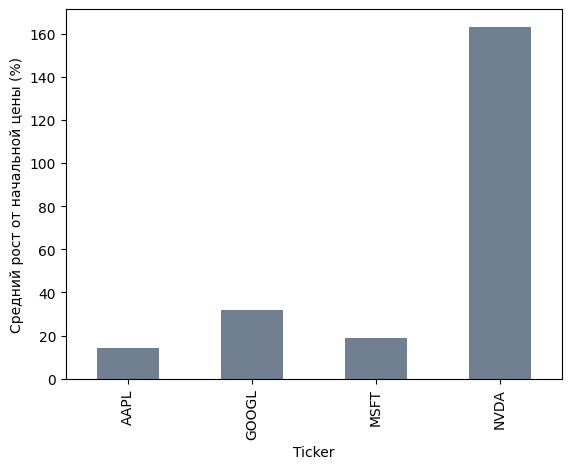

In [33]:
# Находим первую цену для каждого тикера
first_prices = df_stocks.groupby('Ticker')['Close'].transform('first')
# Считаем рост в процентах от начальной точки
df_stocks['Growth'] = (df_stocks['Close'] / first_prices - 1) * 100

# Теперь строим график СРЕДНЕГО роста за весь период
visul = df_stocks.groupby('Ticker')['Growth'].mean()
visul.plot(kind='bar', color='slategray')
plt.ylabel('Средний рост от начальной цены (%)')